In [19]:
import torch
from usta_model import UstaModel
from usta_tokenizer import UstaTokenizer

u_tokenizer = UstaTokenizer("tokenizer.json")

prompt = "the capital of united"

tokens = u_tokenizer.encode(prompt)
tokens.shape

torch.Size([7])

In [2]:

torch.manual_seed(1)
u_model = UstaModel(vocab_size=len(u_tokenizer.vocab), embedding_dim=4, context_length=32)

sentence_meanings_with_atention_context = u_model(tokens)
sentence_meanings_with_atention_context

tensor([[-0.4989,  0.8733, -0.2932,  0.5370],
        [ 0.2544,  0.0915, -0.1126, -0.1856],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.2915,  0.1014,  0.2061,  0.5143],
        [-0.1000,  0.1750, -0.0588,  0.1076],
        [-0.0450,  0.3275,  0.0015,  0.3591],
        [ 0.2325,  0.2253, -0.2238, -0.1362]], grad_fn=<MmBackward0>)

In [3]:
from transformers import Gemma3ForCausalLM

gemma_model = Gemma3ForCausalLM.from_pretrained("google/gemma-3-1b-it")
u_model, gemma_model

c:\Users\Artun\anaconda3\envs\LLM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(UstaModel(
   (embedding): Embedding(64, 4)
   (pos_embedding): Embedding(64, 4)
   (self_attation): UstaCausalAttention(
     (q_weights): Linear(in_features=4, out_features=4, bias=False)
     (k_weights): Linear(in_features=4, out_features=4, bias=False)
     (v_weights): Linear(in_features=4, out_features=4, bias=False)
     (dropout): Dropout(p=0.5, inplace=False)
   )
 ),
 Gemma3ForCausalLM(
   (model): Gemma3TextModel(
     (embed_tokens): Gemma3TextScaledWordEmbedding(262144, 1152, padding_idx=0)
     (layers): ModuleList(
       (0-25): 26 x Gemma3DecoderLayer(
         (self_attn): Gemma3Attention(
           (q_proj): Linear(in_features=1152, out_features=1024, bias=False)
           (k_proj): Linear(in_features=1152, out_features=256, bias=False)
           (v_proj): Linear(in_features=1152, out_features=256, bias=False)
           (o_proj): Linear(in_features=1024, out_features=1152, bias=False)
           (q_norm): Gemma3RMSNorm((256,), eps=1e-06)
           (k_norm): Ge

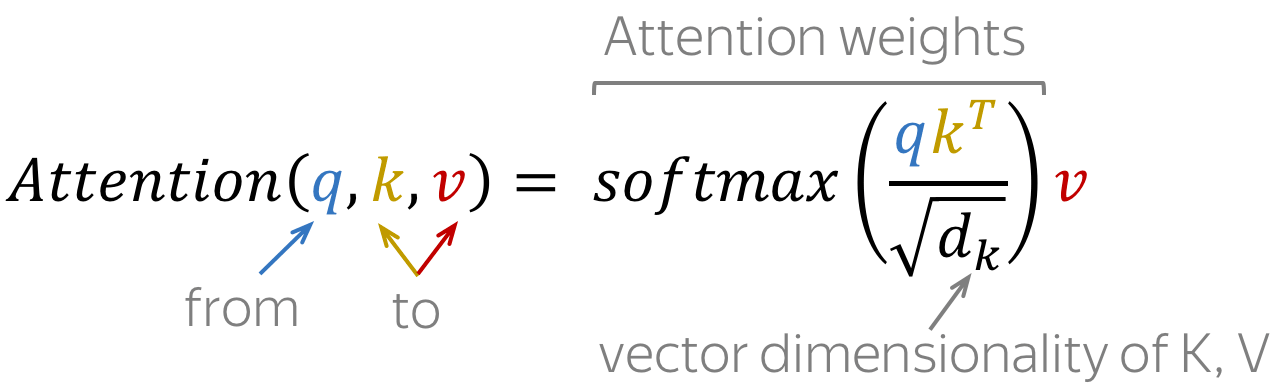

In [4]:
q_weights = torch.nn.Linear(4, 3, bias=False)
k_weights = torch.nn.Linear(4, 3, bias=False)
v_weights = torch.nn.Linear(4, 3, bias=False)

q_of_sentence = q_weights(sentence_meanings_with_atention_context)
k_of_sentence = k_weights(sentence_meanings_with_atention_context)
v_of_sentence = v_weights(sentence_meanings_with_atention_context)
print(q_weights.weight)

q_of_sentence.shape, k_of_sentence.shape, v_of_sentence.shape

Parameter containing:
tensor([[-0.0408,  0.1524, -0.4963,  0.4446],
        [-0.1089, -0.4589,  0.3446, -0.1352],
        [ 0.4541, -0.3396, -0.4642, -0.3756]], requires_grad=True)


(torch.Size([7, 3]), torch.Size([7, 3]), torch.Size([7, 3]))

In [5]:
attention_scores = q_of_sentence @ k_of_sentence.T
attention_weights = torch.softmax(attention_scores / k_of_sentence.shape[-1] ** 0.5, dim=1)

context_vector = attention_weights @ v_of_sentence
context_vector

tensor([[-0.1229, -0.1153, -0.0929],
        [-0.1211, -0.1147, -0.0921],
        [-0.1214, -0.1141, -0.0917],
        [-0.1222, -0.1137, -0.0915],
        [-0.1217, -0.1143, -0.0919],
        [-0.1220, -0.1145, -0.0921],
        [-0.1212, -0.1150, -0.0923]], grad_fn=<MmBackward0>)

In [6]:
from plot_tokens import plot_tokens

u_sentences = [
  {
    "words": q_of_sentence.detach().numpy(),
    "labels": u_tokenizer.tokenize(prompt),
    "color": "blue",
  },
  {
    "words": k_of_sentence.detach().numpy(),
    "labels": u_tokenizer.tokenize(prompt),
    "color": "purple",
  },
  {
    "words": v_of_sentence.detach().numpy(),
    "labels": u_tokenizer.tokenize(prompt),
    "color": "orange",
  },
  {
    "words": context_vector.detach().numpy(),
    "labels": u_tokenizer.tokenize(prompt),
    "color": "green",
  },
]

plot_tokens(u_sentences, "Query, Key, Value and Context Vector Space")

Causal Self Attention


In [7]:
attention_weights

tensor([[0.1523, 0.1420, 0.1403, 0.1365, 0.1426, 0.1409, 0.1453],
        [0.1387, 0.1418, 0.1436, 0.1480, 0.1426, 0.1449, 0.1405],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429],
        [0.1516, 0.1439, 0.1411, 0.1342, 0.1431, 0.1393, 0.1467],
        [0.1447, 0.1427, 0.1424, 0.1416, 0.1428, 0.1425, 0.1434],
        [0.1472, 0.1427, 0.1417, 0.1396, 0.1428, 0.1418, 0.1442],
        [0.1387, 0.1415, 0.1434, 0.1483, 0.1424, 0.1453, 0.1404]],
       grad_fn=<SoftmaxBackward0>)

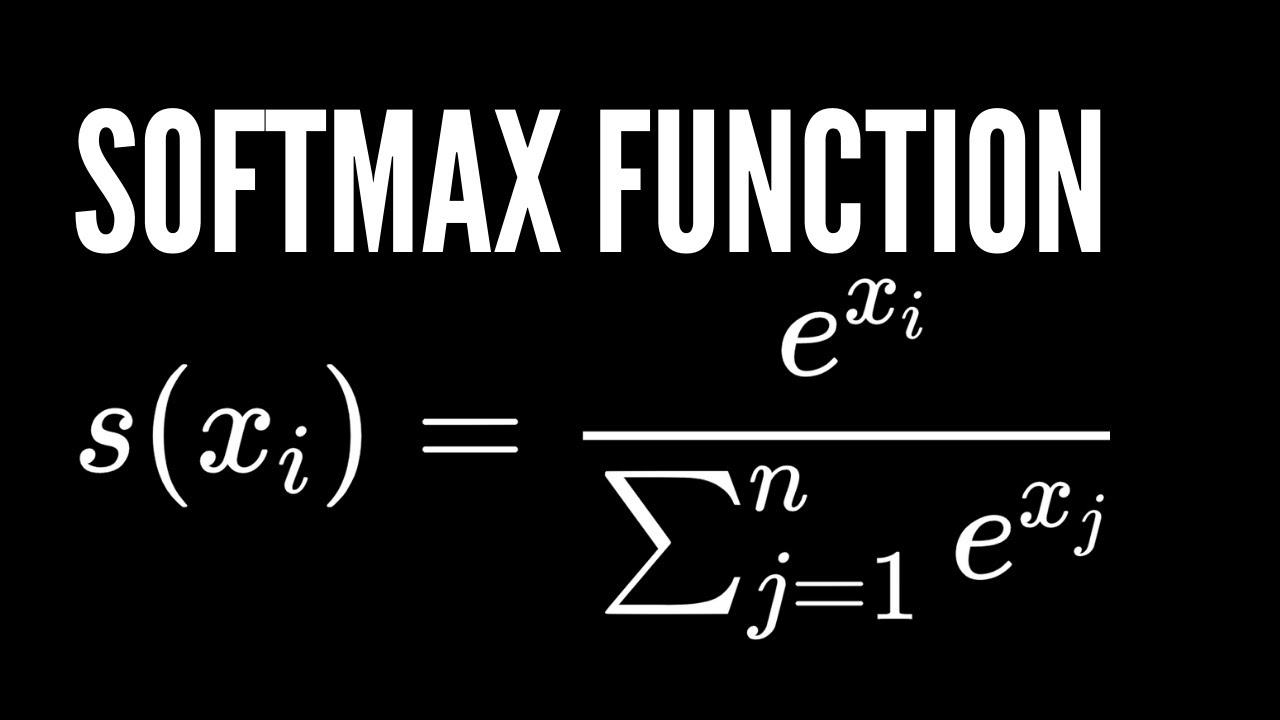

In [8]:
mask = torch.tril(torch.ones(7, 7))
mask

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1.]])

In [9]:
attention_weights = torch.randn(7, 7)

masked_attention_weights = attention_weights.masked_fill(mask == 0, -torch.inf)
masked_attention_weights

tensor([[-0.3115,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.5054,  0.6357,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.4618,  0.4607, -0.9321,    -inf,    -inf,    -inf,    -inf],
        [ 1.1382, -0.0929,  0.7553, -0.3743,    -inf,    -inf,    -inf],
        [-0.4400,  0.3497, -0.9797, -1.3293,  0.3908,    -inf,    -inf],
        [ 1.1120, -0.9464,  1.6345,  1.2819,  0.4398, -0.4839,    -inf],
        [-0.3545,  1.3506,  1.8432, -1.2497, -1.1859, -0.9494,  1.8357]])

In [10]:
torch.softmax(masked_attention_weights, dim=1)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4675, 0.5325, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2415, 0.6076, 0.1509, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4558, 0.1331, 0.3108, 0.1004, 0.0000, 0.0000, 0.0000],
        [0.1540, 0.3393, 0.0898, 0.0633, 0.3536, 0.0000, 0.0000],
        [0.2122, 0.0271, 0.3578, 0.2515, 0.1083, 0.0430, 0.0000],
        [0.0387, 0.2129, 0.3485, 0.0158, 0.0169, 0.0213, 0.3459]])

In [11]:
mask = torch.tril(torch.ones(7, 7))
masked_attention_weights = attention_weights.masked_fill(mask == 0, -torch.inf)
masked_attention_weights

softmaxed_attention_weights = torch.softmax(masked_attention_weights, dim=1)
softmaxed_attention_weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4675, 0.5325, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2415, 0.6076, 0.1509, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4558, 0.1331, 0.3108, 0.1004, 0.0000, 0.0000, 0.0000],
        [0.1540, 0.3393, 0.0898, 0.0633, 0.3536, 0.0000, 0.0000],
        [0.2122, 0.0271, 0.3578, 0.2515, 0.1083, 0.0430, 0.0000],
        [0.0387, 0.2129, 0.3485, 0.0158, 0.0169, 0.0213, 0.3459]])

In [16]:
dropout_rate = 0.5
torch.manual_seed(1)
dropout = torch.nn.Dropout(dropout_rate)
dropout(softmaxed_attention_weights)

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4830, 1.2151, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6786, 0.1796, 0.1266, 0.0000, 0.0000, 0.0000],
        [0.4244, 0.0000, 0.7157, 0.5030, 0.2167, 0.0860, 0.0000],
        [0.0774, 0.4259, 0.6970, 0.0316, 0.0000, 0.0427, 0.6917]])

In [17]:
from usta_causal_attention import UstaCausalAttention

import torch
import torch.nn as nn

class UstaMultiHeadAttention(nn.Module):
  def __init__(self, embedding_dim, output_dim, context_length, num_heads, dropout_rate = 0):
    super().__init__()

    self.heads = nn.ModuleList(
      [UstaCausalAttention(embedding_dim, output_dim, context_length, dropout_rate) for _ in range(num_heads)]
    )

  def forward(self, x):
    attention_outs = []
    for head in self.heads:
      head_out = head(x)
      attention_outs.append(head_out)

    return torch.cat(attention_outs, dim=1)
  
multi_head_attention = UstaMultiHeadAttention(4, 4, 32, 2, dropout_rate=0)

out = multi_head_attention(torch.randn(4, 4))
out.shape, out

(torch.Size([4, 8]),
 tensor([[-0.9650,  0.4106, -0.5382, -0.2936, -0.6830, -1.7639, -0.2041,  0.1835],
         [-0.1383, -0.8245,  0.7907,  0.2918,  0.6980,  1.1659,  1.2595, -0.0854],
         [-0.1144, -0.9190,  0.8525,  0.3227,  0.4236,  0.4406,  0.6430,  0.0270],
         [-0.2852, -0.6560,  0.5767,  0.1650,  0.0581, -0.2263,  0.2025,  0.1328]],
        grad_fn=<CatBackward0>))